# Create Scatter Plots Showing Diversity in Heat Wave and Cold Snap Parameters


In [1]:
# Start by importing the packages we need:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from datetime import timedelta


## Suppress Future Warnings


In [2]:
# Suppress future warnings:
warnings.simplefilter(action='ignore', category=FutureWarning)


## Set the Directory Structure

In [3]:
# Set the data input and output directories:
metadata_input_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/'
events_data_input_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/thermal_events_data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/figures/regional_results/'


## Plot the Diversity in Thermal Event Weather Characteristics


In [4]:
def plot_hw_cs_events(region: int, hw_cs: str, events_data_input_dir: str, metadata_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):

    # Read in NERC region name file and extract the TPL-08 region name:
    nerc = pd.read_csv((metadata_input_dir + 'nerc_tpl08_region_names.csv'))
    nerc_name = nerc.loc[nerc['short_name'] == region, 'long_name'].item()
    
    # Extract the heat wave or cold snap library data for a given NERC region:
    if hw_cs == 'HW':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'hw_library_expanded.csv'))
    elif hw_cs == 'CS':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'cs_library_expanded.csv'))

    # Subset to just the data for region you want to use:
    subset_df = hw_cs_df[(hw_cs_df['Region'] == region)].copy()
    
    # Bin the regions impacted values and scale them for the scatter plot:
    subset_df['Regions_Impacted_Normalized'] = ((subset_df['Regions_Impacted'] - 1) / (subset_df['Regions_Impacted'].max() - 1)).round(2)

    # Set the rankings by temperature:
    if hw_cs == 'HW':
       subset_df = subset_df.sort_values('T_Max_Min', ascending=False)
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1
    if hw_cs == 'CS':
       subset_df = subset_df.sort_values('T_Max_Min')
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1    

    # Sort by date and reset the index:
    subset_df = subset_df.sort_values('Start')
    subset_df.reset_index(inplace=True, drop=True)
    
    # For cold snaps, shift the centroid date to plot whole winter seasons together:
    if hw_cs == 'CS':
       subset_df.loc[(subset_df['Center_DOY'] > 182), 'Center_DOY'] = subset_df['Center_DOY']-365

    # Set the plot parameters based on plotting heat waves or cold snaps:
    if hw_cs == 'HW':
       cmap = plt.get_cmap('Reds', 21)
       xticks = [121, 152, 182, 213, 244, 274]
       xticklabels = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
       xmin = 121
       xmax = 274 
       ylabel = 'Maximum Temperature [$^\circ$F]'
       title = ('Heat Wave Events in ' + nerc_name + '\n 1980-2024, N=' + str(len(subset_df)))
    elif hw_cs == 'CS':
       cmap = plt.get_cmap('Blues', 21)
       xticks = [-61, -31, 1, 32, 60, 91]
       xticklabels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
       xmin = -61
       xmax = 91   
       ylabel = 'Minimum Temperature [$^\circ$F]'
       title = ('Cold Snap Events in ' + nerc_name + '\n 1980-2024, N=' + str(len(subset_df)))

    # Identify the top-40 events based on the maximum or minimum event temperature:
    top40_events_df = subset_df.loc[(subset_df['T_Rank'] <= 40)].copy()
    nottop40_events_df = subset_df.loc[(subset_df['T_Rank'] > 40)].copy()
    
    # Make the scatter plot:
    plt.figure(figsize=(20, 10))
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.axisbelow'] = True
    sc = plt.scatter(nottop40_events_df['Center_DOY'], nottop40_events_df['T_Max_Min'], s=(((nottop40_events_df['Regions_Impacted_Normalized']+0.1)*750)), c=nottop40_events_df['Duration'], 
                     edgecolors='k', linestyle='--', cmap=cmap, vmin=0, vmax=21)
    top40sc = plt.scatter(top40_events_df['Center_DOY'], top40_events_df['T_Max_Min'], s=(((top40_events_df['Regions_Impacted_Normalized']+0.1)*750)), c=top40_events_df['Duration'], 
                          edgecolors='k', linestyle='-', cmap=cmap, vmin=0, vmax=21, label='Size $\\propto$ # of NERC Regions Impacted')
    cbar = plt.colorbar(sc, ticks=[0, 7, 14, 21])
    cbar.ax.set_ylabel('Event Duration [Days]')
    plt.legend(loc='best', prop={'size': 18})
    plt.grid()
    plt.xticks(xticks, xticklabels)
    plt.xlim([xmin, xmax])
    plt.ylim([(subset_df['T_Max_Min'].min()-1.5), (subset_df['T_Max_Min'].max()+1.5)])
    plt.ylabel(ylabel)
    plt.title(title)

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + str(region) + '_' + hw_cs + '_Events.png'), dpi=image_resolution, bbox_inches='tight')
       plt.close()


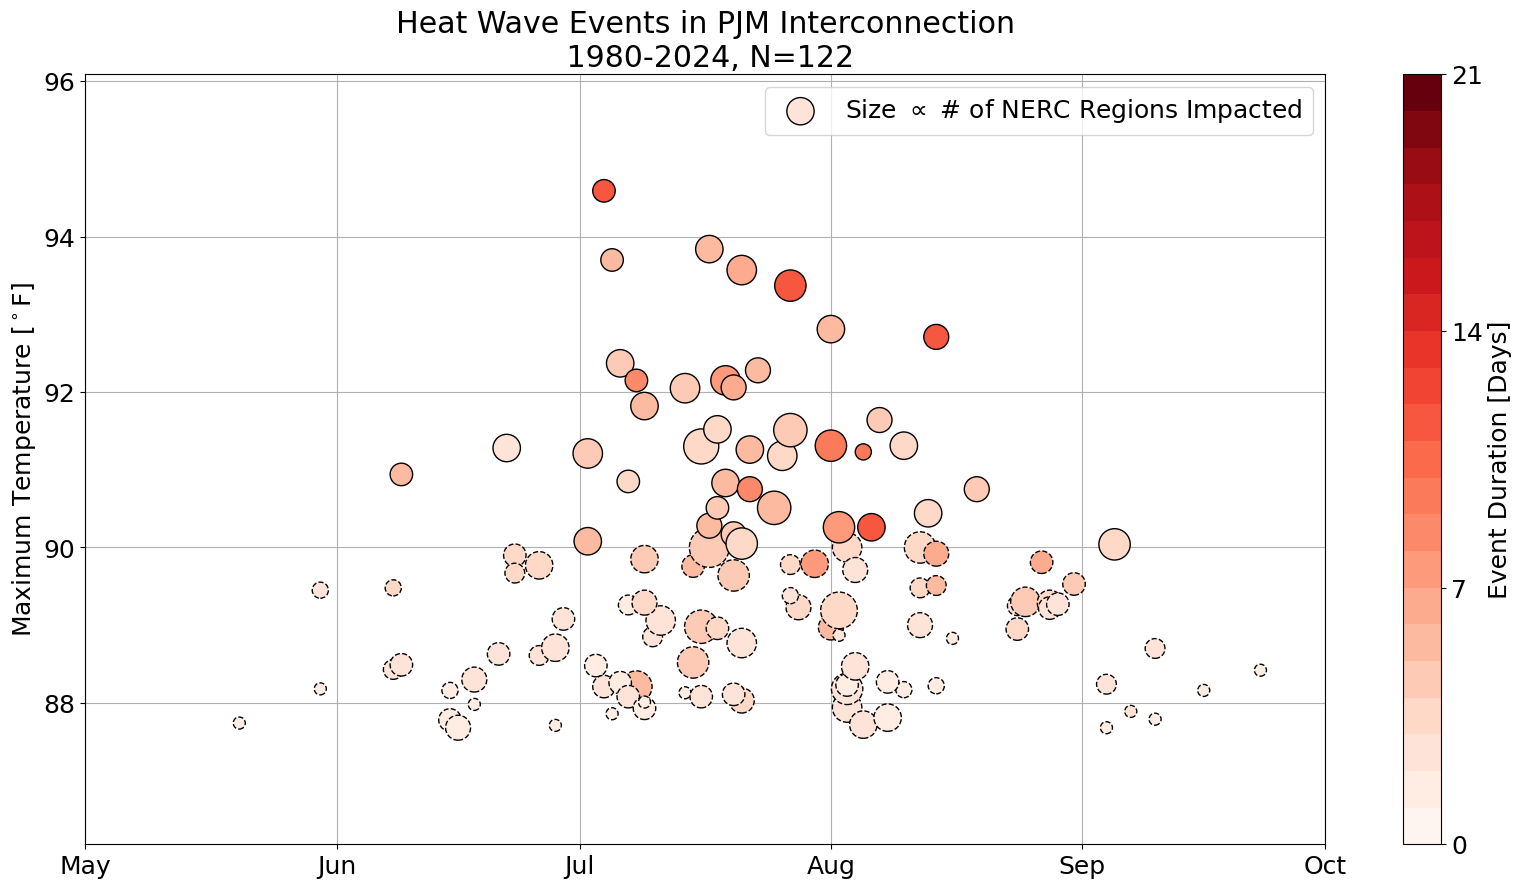

In [5]:
# Test the function:
plot_hw_cs_events(region = 'PJM',
                  hw_cs = 'HW',
                  events_data_input_dir = events_data_input_dir,
                  metadata_input_dir = metadata_input_dir,
                  image_output_dir = image_output_dir, 
                  image_resolution = 150,
                  save_images = False)


In [6]:
# Loop over the NERC TPL-008-1 regions and make the plot for each region:
for region in ['CA', 'ERCOT', 'FL', 'GB', 'ISONE', 'MISO-N', 'MISO-S', 'NYISO', 'PJM', 'PNW', 'RM', 'SERC', 'SPP-N', 'SPP-S', 'SW']:

    # Loop over heat wave and cold snap event types:
    for event_type in ['HW', 'CS']:
    
        # Make the plot:
        plot_hw_cs_events(region = region,
                          hw_cs = event_type,
                          events_data_input_dir = events_data_input_dir,
                          metadata_input_dir = metadata_input_dir,
                          image_output_dir = image_output_dir, 
                          image_resolution = 150,
                          save_images = True)


## Plot the Diversity in Thermal Event Weather and Load Characteristics

Note that this will only work for NERC TPL-008-1 regions in the WECC because they're the only ones with the requisite load data.


In [7]:
def plot_hw_cs_histograms(region: int, hw_cs: str, events_data_input_dir: str, metadata_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):

    # Read in NERC region name file and extract the TPL-08 region name:
    nerc = pd.read_csv((metadata_input_dir + 'nerc_tpl08_region_names.csv'))
    nerc_name = nerc.loc[nerc['short_name'] == region, 'long_name'].item()
       
    # Extract the heat wave or cold snap library data for a given NERC region:
    if hw_cs == 'HW':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'hw_library_expanded.csv'))
    elif hw_cs == 'CS':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'cs_library_expanded.csv'))

    # Subset to just the data for region you want to use:
    subset_df = hw_cs_df[(hw_cs_df['Region'] == region)].copy()
    
    # Set the rankings by temperature:
    if hw_cs == 'HW':
       subset_df = subset_df.sort_values('T_Max_Min', ascending=False)
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1
    if hw_cs == 'CS':
       subset_df = subset_df.sort_values('T_Max_Min')
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1    

    # Sort by date and reset the index:
    subset_df = subset_df.sort_values('Start')
    subset_df.reset_index(inplace=True, drop=True)

    # Convert the peak demands from MW to GW:
    subset_df['Region_Load_Peak_MWh'] = subset_df['Region_Load_Peak_MWh']/1000
    subset_df['WECC_Load_Peak_MWh'] = subset_df['WECC_Load_Peak_MWh']/1000
    
    # Identify the top-40 events based on the maximum or minimum event temperature:
    top40_events_df = subset_df.loc[(subset_df['T_Rank'] <= 40)].copy()
   
    # Create the bins:
    temperature_bins = np.arange(subset_df['T_Max_Min'].min(), subset_df['T_Max_Min'].max(), ((subset_df['T_Max_Min'].max() - subset_df['T_Max_Min'].min()) / 20))
    duration_bins = np.arange(0, 21, 1)
    region_load_bins = np.arange(subset_df['Region_Load_Peak_MWh'].min(), subset_df['Region_Load_Peak_MWh'].max(), ((subset_df['Region_Load_Peak_MWh'].max() - subset_df['Region_Load_Peak_MWh'].min()) / 20))
    wecc_load_bins = np.arange(subset_df['WECC_Load_Peak_MWh'].min(), subset_df['WECC_Load_Peak_MWh'].max(), ((subset_df['WECC_Load_Peak_MWh'].max() - subset_df['WECC_Load_Peak_MWh'].min()) / 20))

    # Make the histogram plot:
    plt.figure(figsize=(20, 20))
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.axisbelow'] = True

    plt.subplot(221)
    plt.hist(subset_df['T_Max_Min'], bins=temperature_bins, density=False, histtype='stepfilled', facecolor='k')
    plt.hist(top40_events_df['T_Max_Min'], bins=temperature_bins, density=False, histtype='step', color='r', linewidth=3)
    if hw_cs == 'HW':
       plt.xlabel('Maximum Temperature [$^\circ$F]')
    else:
       plt.xlabel('Minimum Temperature [$^\circ$F]') 
    plt.ylabel('Count')
    plt.title('a)', loc='left', fontsize=16)
    plt.title('Temperature')

    plt.subplot(222)
    plt.hist(subset_df['Duration'], bins=duration_bins, density=False, histtype='stepfilled', facecolor='k')
    plt.hist(top40_events_df['Duration'], bins=duration_bins, density=False, histtype='step', color='r', linewidth=3)
    plt.xlabel('Duration [Days]') 
    plt.ylabel('Count')
    plt.title('b)', loc='left', fontsize=16)
    plt.title('Duration')

    plt.subplot(223)
    plt.hist(subset_df['Region_Load_Peak_MWh'], bins=region_load_bins, density=False, histtype='stepfilled', facecolor='k')
    plt.hist(top40_events_df['Region_Load_Peak_MWh'], bins=region_load_bins, density=False, histtype='step', color='r', linewidth=3)
    plt.xlabel('Regional Peak Total Demand [GW]') 
    plt.ylabel('Count')
    plt.title('c)', loc='left', fontsize=16)
    plt.title(('Peak Total Demand in ' + region))
    
    plt.subplot(224)
    plt.hist(subset_df['WECC_Load_Peak_MWh'], bins=wecc_load_bins, density=False, histtype='stepfilled', facecolor='k')
    plt.hist(top40_events_df['WECC_Load_Peak_MWh'], bins=wecc_load_bins, density=False, histtype='step', color='r', linewidth=3)
    plt.xlabel('Interconnection Peak Total Demand [GW]') 
    plt.ylabel('Count')
    plt.title('d)', loc='left', fontsize=16)
    plt.title('WECC Peak Total Demand')

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + str(region) + '_' + hw_cs + '_Histograms.png'), dpi=image_resolution, bbox_inches='tight')
       plt.close()


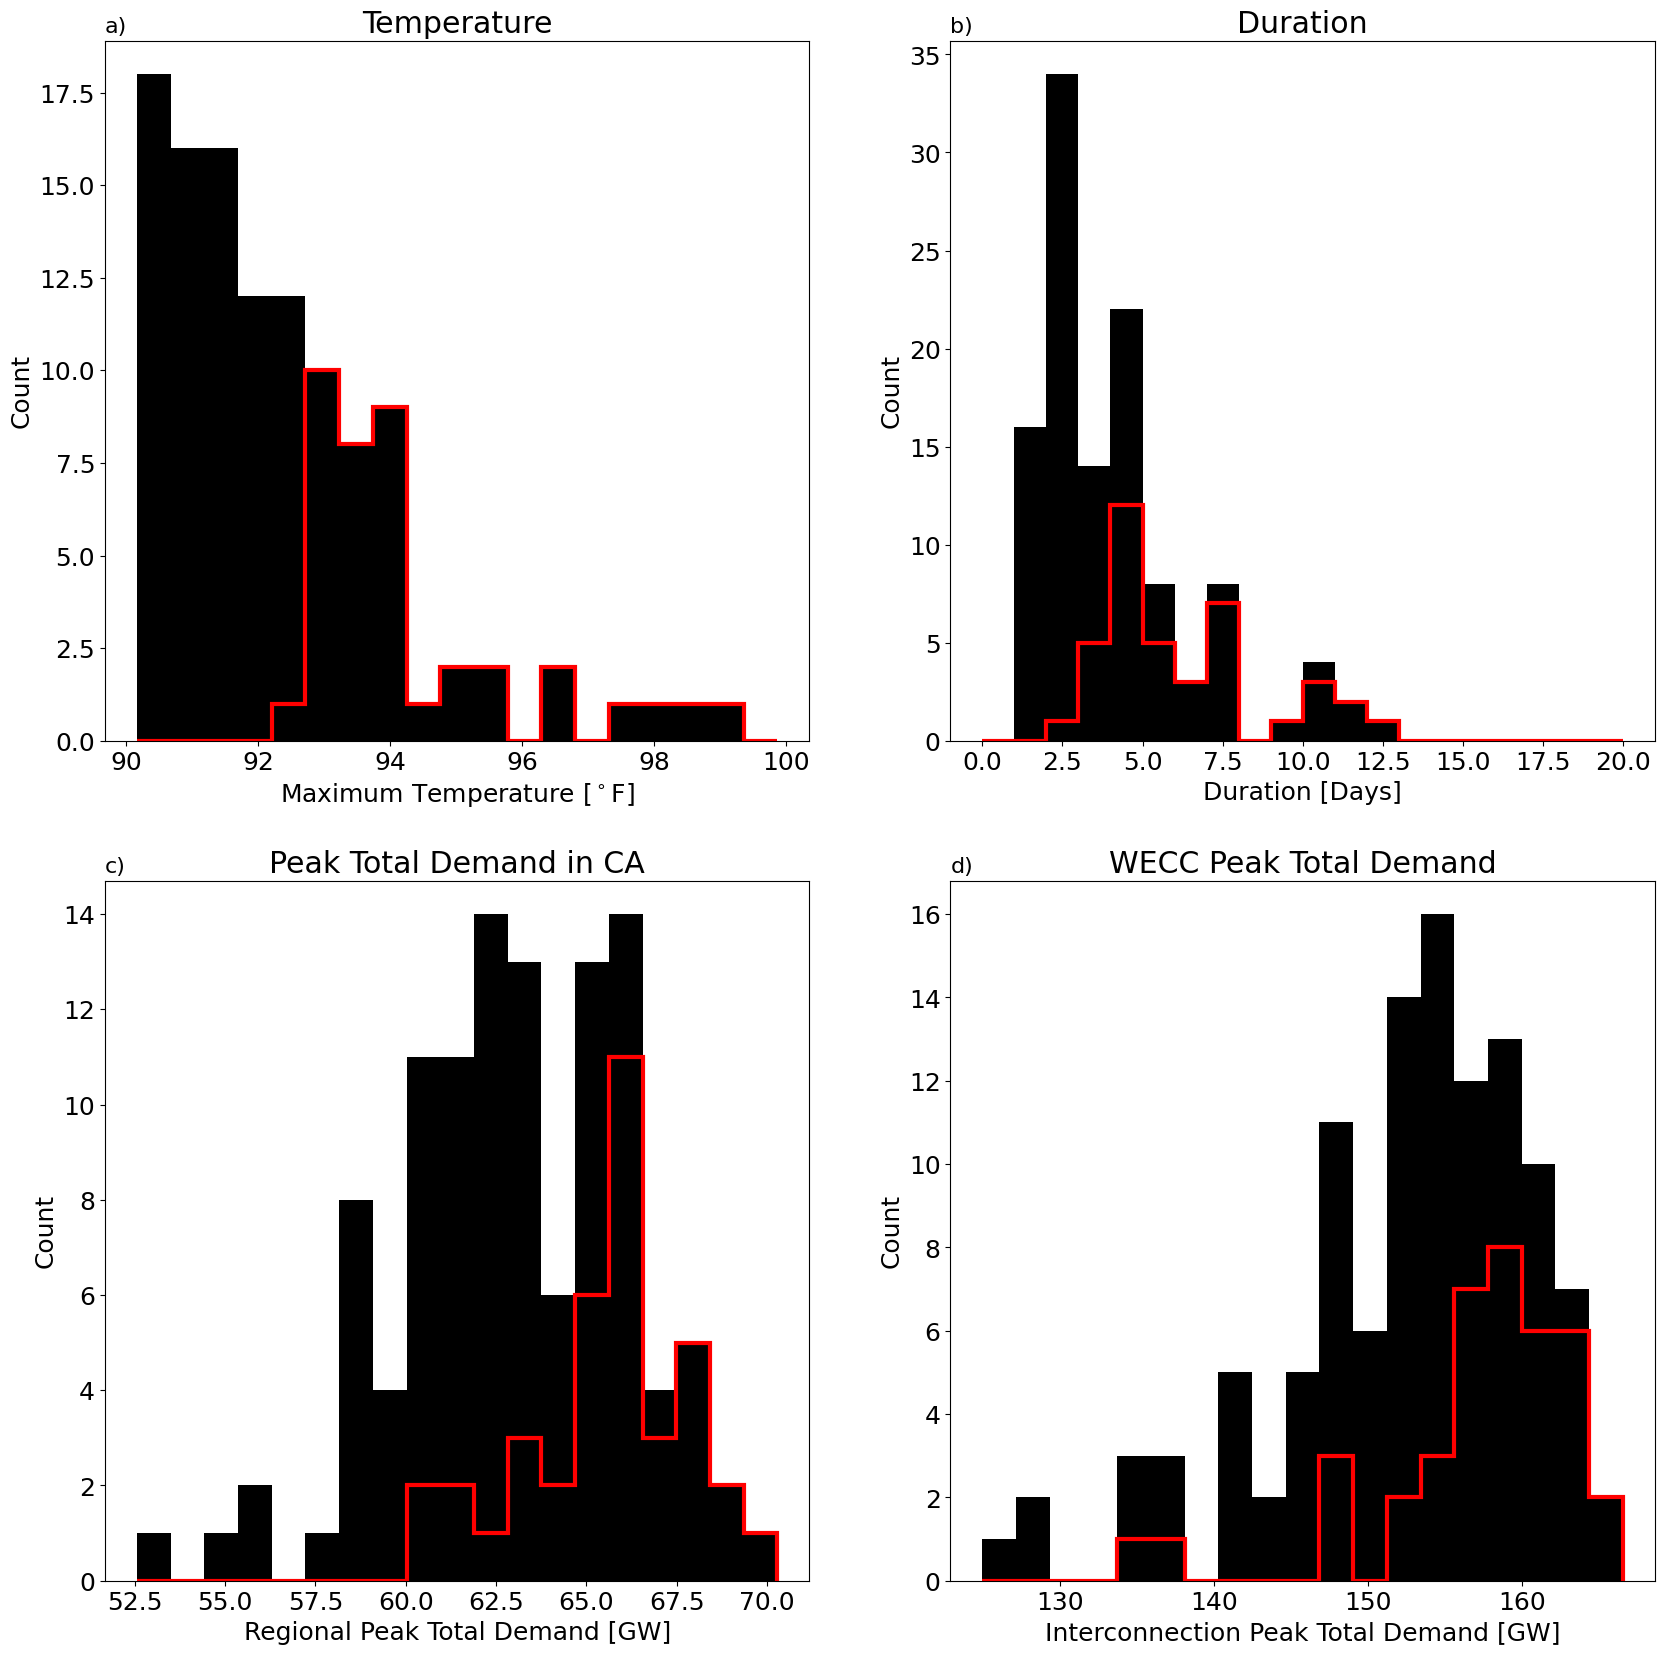

In [8]:
# Test the function:
plot_hw_cs_histograms(region = 'CA',
                      hw_cs = 'HW',
                      events_data_input_dir = events_data_input_dir,
                      metadata_input_dir = metadata_input_dir,
                      image_output_dir = image_output_dir, 
                      image_resolution = 150,
                      save_images = False)


In [9]:
# Loop over the NERC TPL-008-1 regions in the WECC and make the plot for each region:
for region in ['CA', 'GB', 'PNW', 'RM', 'SW']:

    # Loop over heat wave and cold snap event types:
    for event_type in ['HW', 'CS']:
    
        # Make the plot:
        plot_hw_cs_histograms(region = region,
                              hw_cs = event_type,
                              events_data_input_dir = events_data_input_dir,
                              metadata_input_dir = metadata_input_dir,
                              image_output_dir = image_output_dir, 
                              image_resolution = 150,
                              save_images = True)


## Plot the Rankings of Events Based on Different Variables

Note that this will only work for NERC TPL-008-1 regions in the WECC because they're the only ones with the requisite load data.

In [10]:
def plot_hw_cs_rankings(region: int, hw_cs: str, events_data_input_dir: str, metadata_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):

    # Read in NERC region name file and extract the TPL-08 region name:
    nerc = pd.read_csv((metadata_input_dir + 'nerc_tpl08_region_names.csv'))
    nerc_name = nerc.loc[nerc['short_name'] == region, 'long_name'].item()
       
    # Extract the heat wave or cold snap library data for a given NERC region:
    if hw_cs == 'HW':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'hw_library_expanded.csv'))
    elif hw_cs == 'CS':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'cs_library_expanded.csv'))

    # Subset to just the data for region you want to use:
    subset_df = hw_cs_df[(hw_cs_df['Region'] == region)].copy()
    
    # Set the rankings by temperature:
    if hw_cs == 'HW':
       subset_df = subset_df.sort_values('T_Max_Min', ascending=False)
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1
    if hw_cs == 'CS':
       subset_df = subset_df.sort_values('T_Max_Min')
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1    

    # Set the rankings by WECC load peak:
    subset_df = subset_df.sort_values('WECC_Load_Peak_MWh', ascending=False)
    subset_df['WECC_Peak_Rank'] = range(len(subset_df))
    subset_df['WECC_Peak_Rank'] = subset_df['WECC_Peak_Rank'] + 1

    # Set the rankings by NERC TPL-008-1 region load peak:
    subset_df = subset_df.sort_values('Region_Load_Peak_MWh', ascending=False)
    subset_df['Region_Peak_Rank'] = range(len(subset_df))
    subset_df['Region_Peak_Rank'] = subset_df['Region_Peak_Rank'] + 1

    # Set the rankings by NERC TPL-008-1 region net load peak:
    subset_df = subset_df.sort_values('Region_Net_Load_Peak_MWh', ascending=False)
    subset_df['Region_Net_Peak_Rank'] = range(len(subset_df))
    subset_df['Region_Net_Peak_Rank'] = subset_df['Region_Net_Peak_Rank'] + 1

    # Sort by date and reset the index:
    subset_df = subset_df.sort_values('Start')
    subset_df.reset_index(inplace=True, drop=True)

    # Identify the top-40 events based on the maximum or minimum event temperature:
    top40_events_df = subset_df.loc[(subset_df['T_Rank'] <= 40)].copy()

    # Create a 1:1 line for plotting:
    one_to_one = np.arange(0, 300, 10)
    ticks = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
    ticklabels = ['0','','20','','40','','60','','80','','100','','120','','140','','160','','180','','200']
   
    # Make the scatter plot:
    plt.figure(figsize=(20, 20))
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.axisbelow'] = True

    plt.subplot(211)
    plt.plot(one_to_one,one_to_one,'gray', linewidth=3, label = '1:1')
    plt.scatter(subset_df['T_Rank'], subset_df['Region_Peak_Rank'], s=35, c='k')
    plt.scatter(top40_events_df['T_Rank'], top40_events_df['Region_Peak_Rank'], s=35, c='r')
    plt.xticks(ticks, ticklabels)
    plt.xlim(0, len(subset_df)+3)
    plt.ylim(0, len(subset_df)+3)
    plt.grid()
    if hw_cs == 'HW':
       plt.xlabel('Temperature Rank [1 = Hottest]') 
    else:
       plt.xlabel('Temperature Rank [1 = Coldest]') 
    plt.ylabel('Region Peak Demand Rank [1 = Highest]')
    plt.title('a)', loc='left', fontsize=16)
    plt.title(('Heat Wave Events in ' + nerc_name + '\n 1980-2024, N=' + str(len(subset_df))))

    plt.subplot(212)
    plt.plot(one_to_one,one_to_one,'gray', linewidth=3, label = '1:1')
    plt.scatter(subset_df['Region_Peak_Rank'], subset_df['WECC_Peak_Rank'], s=35, c='k')
    plt.scatter(top40_events_df['Region_Peak_Rank'], top40_events_df['WECC_Peak_Rank'], s=35, c='r')
    plt.xticks(ticks, ticklabels)
    plt.xlim(0, len(subset_df)+3)
    plt.ylim(0, len(subset_df)+3)
    plt.grid()
    plt.xlabel('Region Peak Demand Rank [1 = Highest]') 
    plt.ylabel('Interconnection Peak Demand Rank [1 = Highest]')
    plt.title('b)', loc='left', fontsize=16)
        
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + str(region) + '_' + hw_cs + '_Rankings.png'), dpi=image_resolution, bbox_inches='tight')
       plt.close()

    return subset_df
    

,UID,NERC,Region,Start,End,Center,Center_DOY,T_Max_Min,Duration,Regions_Impacted,WECC_Load_Peak_MWh,WECC_Net_Load_Peak_MWh,Unnamed: 12,Region_Load_Peak_MWh,Region_Net_Load_Peak_MWh,T_Rank,WECC_Peak_Rank,Region_Peak_Rank,Region_Net_Peak_Rank
48,HW_NERC11_Event88,11,PNW,7/28/16,7/29/16,7/28/16,210,86.74,2,6,160360.0,157022.0,3338,27340.0,26996.0,75,10,23,27


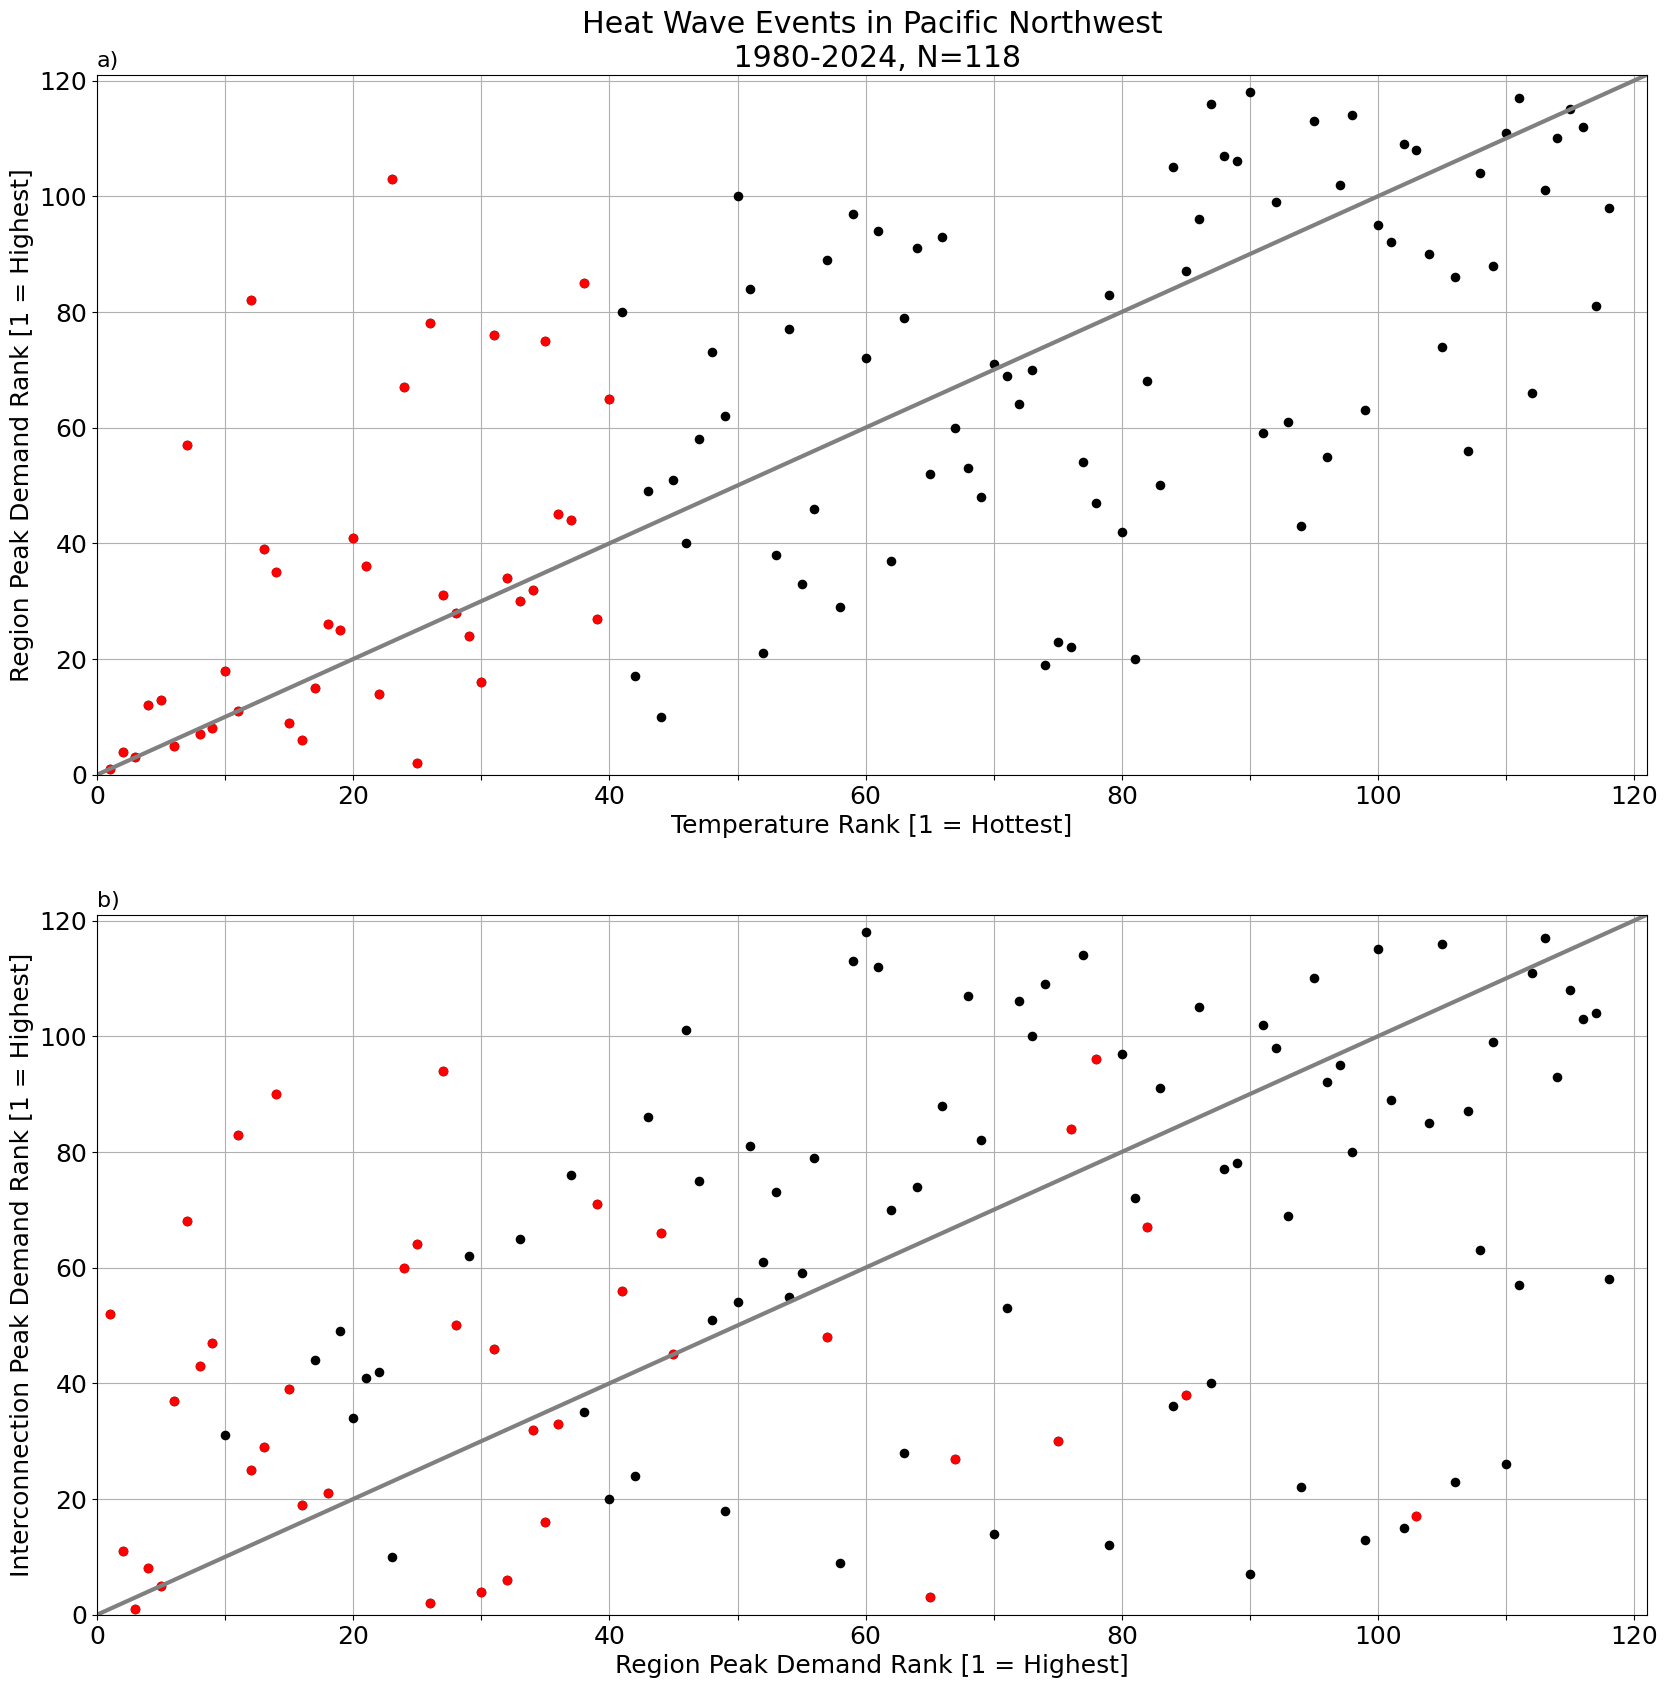

In [15]:
# Test the function:
output_df = plot_hw_cs_rankings(region = 'PNW',
                    hw_cs = 'HW',
                    events_data_input_dir = events_data_input_dir,
                    metadata_input_dir = metadata_input_dir,
                    image_output_dir = image_output_dir, 
                    image_resolution = 150,
                    save_images = False)

event_df = output_df[(output_df['UID'] == 'HW_NERC11_Event88')].copy()

event_df


In [228]:
# Loop over the NERC TPL-008-1 regions in the WECC and make the plot for each region:
for region in ['CA', 'GB', 'PNW', 'RM', 'SW']:

    # Loop over heat wave and cold snap event types:
    for event_type in ['HW', 'CS']:
    
        # Make the plot:
        plot_hw_cs_rankings(region = region,
                            hw_cs = event_type,
                            events_data_input_dir = events_data_input_dir,
                            metadata_input_dir = metadata_input_dir,
                            image_output_dir = image_output_dir, 
                            image_resolution = 150,
                            save_images = True)
        

In [ ]:

    #plt.subplot(325)
    #plt.hist(subset_df['Region_Net_Load_Peak_MWh'], bins=region_net_load_bins, density=False, histtype='stepfilled', facecolor='k')
    #plt.hist(top40_events_df['Region_Net_Load_Peak_MWh'], bins=region_net_load_bins, density=False, histtype='step', color='r', linewidth=3)
    #plt.xlabel('Regional Peak Net Demand [GW]') 
    #plt.ylabel('Count')
    #plt.title('e)', loc='left', fontsize=16)
    #plt.title(('Peak Net Demand in ' + region))

    #plt.subplot(326)
    #plt.hist(subset_df['WECC_Net_Load_Peak_MWh'], bins=wecc_net_load_bins, density=False, histtype='stepfilled', facecolor='k')
    #plt.hist(top40_events_df['WECC_Net_Load_Peak_MWh'], bins=wecc_net_load_bins, density=False, histtype='step', color='r', linewidth=3)
    #plt.xlabel('Interconnection Peak Net Demand [GW]') 
    #plt.ylabel('Count')
    #plt.title('f)', loc='left', fontsize=16)
    #plt.title('WECC Peak Net Demand')